# Timelag Analysis: Heating Cases
In this notebook, we'll compare the timelags across our four different heating cases:
* cooling
* high-frequency nanoflares
* intermediate-frequency nanoflares
* low-frequency nanoflares

In [1]:
import os
import sys

import numpy as np
import h5py
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from sunpy.util.metadata import MetaDict
from astropy.coordinates import SkyCoord
import astropy.units as u

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('../scripts/')
from timelags import AIATimeLags

%matplotlib inline

In [2]:
client = dask.distributed.Client(processes=False)
client

Client Scheduler: inproc://128.42.128.76/97674/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 64 Memory: 270.38 GB


## Load Data

In [3]:
aia_cooling = InstrumentSDOAIA([0,10000]*u.s)
aia_cooling.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/SDO_AIA_counts.h5'
aia_high = InstrumentSDOAIA([5000,25000]*u.s)
aia_high.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/SDO_AIA_counts.h5'
aia_intermediate = InstrumentSDOAIA([5000,25000]*u.s)
aia_intermediate.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/SDO_AIA_counts.h5'
aia_low = InstrumentSDOAIA([5000,25000]*u.s)
aia_low.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA_counts.h5'

Now load in all the data for our four heating cases. We'll focus on the NEI cases.

In [6]:
tl_cooling = AIATimeLags(aia_cooling, fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/')

FloatProgress(value=0.0)

In [4]:
tl_high = AIATimeLags(aia_high, 'intensity_maps_high_frequency.h5', fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/')

FloatProgress(value=0.0)

Or if we've already built the HDF5 file, just pass in the filename

In [4]:
tl_high = AIATimeLags(aia_high, 'intensity_maps_high_frequency.h5')

In [8]:
tl_intermediate = AIATimeLags(aia_intermediate, '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/')

FloatProgress(value=0.0)

In [9]:
tl_low = AIATimeLags(aia_low, '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/')

FloatProgress(value=0.0)

## Peek AIA Maps
Take a quick look at the intensity for a given snapshot in time for all channels for four cases.

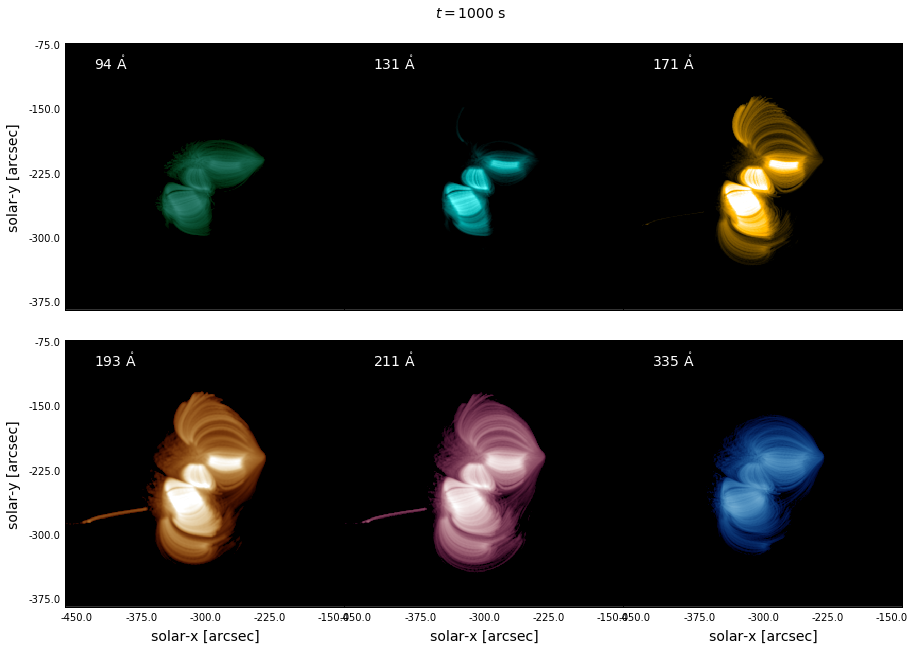

In [10]:
plot_aia_channels(aia_cooling,1000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/')

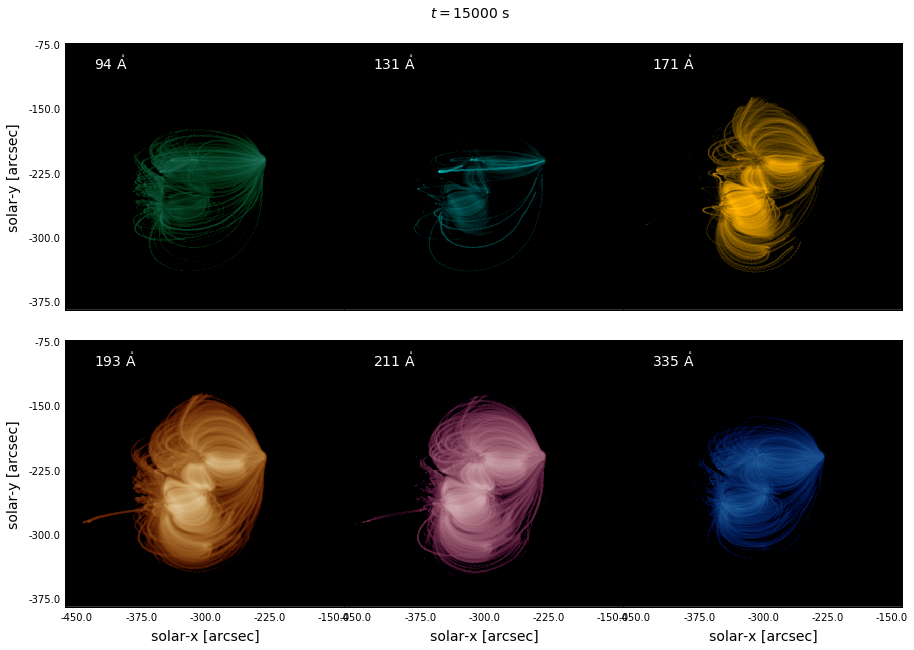

In [11]:
plot_aia_channels(aia_high,15000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/')

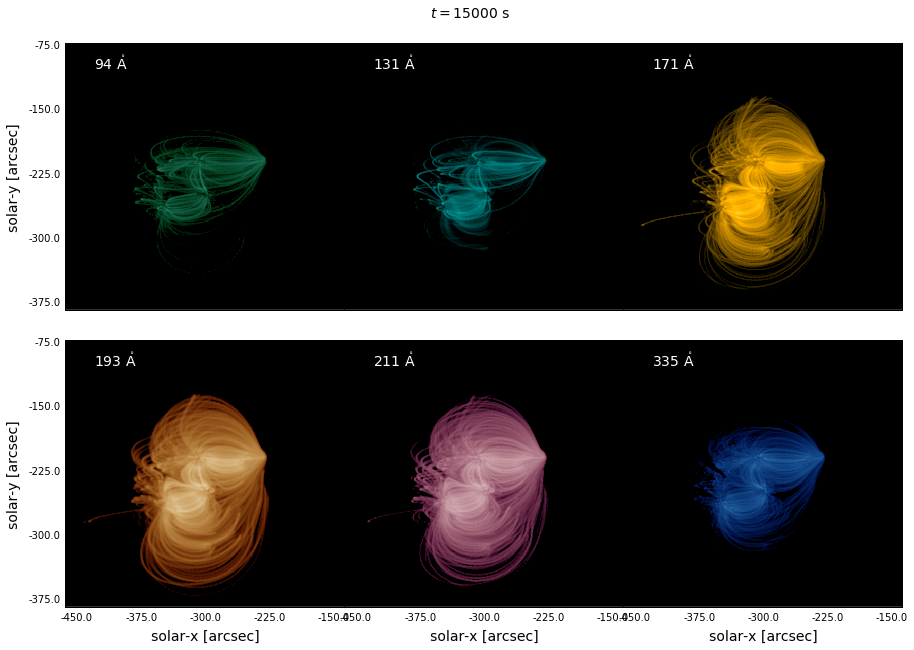

In [12]:
plot_aia_channels(aia_intermediate,15000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/')

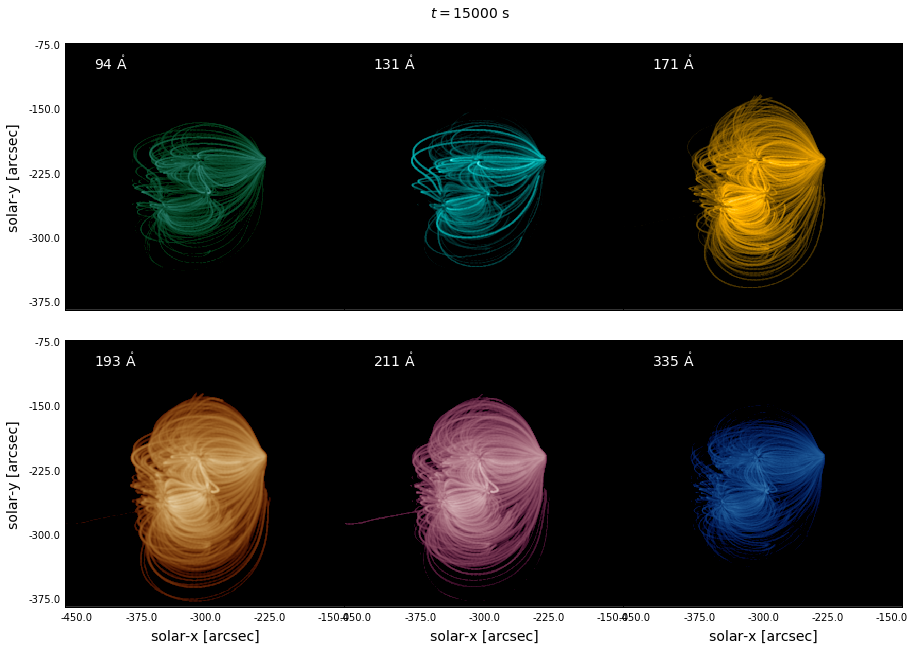

In [13]:
plot_aia_channels(aia_low,15000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/')

## 1D Correlations
Take a 1D slice averaged over a few pixels for each group and compute the timelags for a few channel pairs

In [5]:
xc,yc = -350*u.arcsec, -220*u.arcsec
dx,dy = .5*u.arcsec, .5*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)

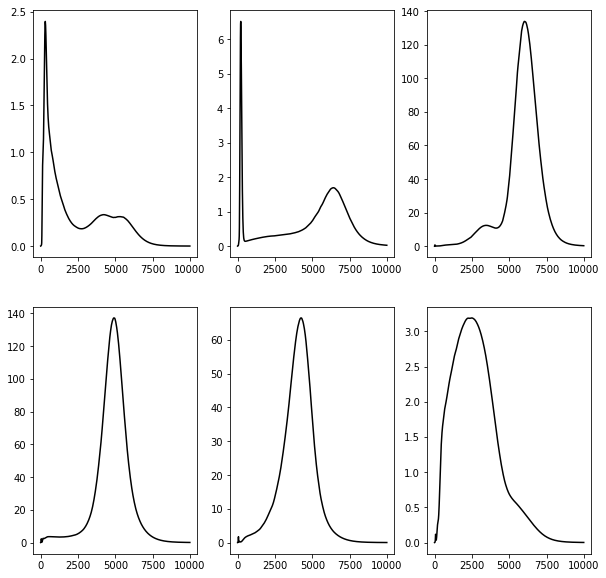

In [62]:
fig,axes = plt.subplots(2,3,figsize=(10,10))
for i,(channel,ax) in enumerate(zip(aia_cooling.channels,axes.flatten())):
    ts_cooling = tl_cooling.make_timeseries(tl_cooling.cubes,channel['name'],lower_left_corner,upper_right_corner)
    ax.plot(aia_cooling.observing_time,ts_cooling,color=f'k')

In [6]:
ts_high = tl_high.make_timeseries(aia_high.channels[0]['name'], lower_left_corner, upper_right_corner)

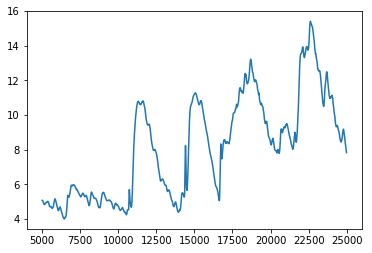

In [7]:
plt.plot(aia_high.observing_time, ts_high)

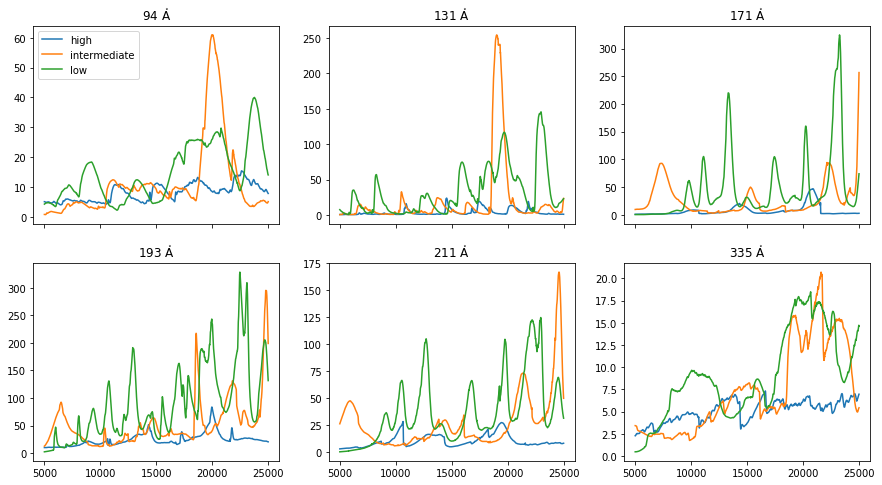

In [63]:
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True)
coords  = (lower_left_corner,upper_right_corner)
for i,(channel,ax) in enumerate(zip(aia_cooling.channels,axes.flatten())):
    ts_high = tl_high.make_timeseries(tl_high.cubes,channel['name'],*coords)
    ax.plot(aia_high.observing_time,ts_high,color=f'C0',label='high')
    ts_intermediate = tl_intermediate.make_timeseries(tl_intermediate.cubes,channel['name'],*coords)
    ax.plot(aia_intermediate.observing_time,ts_intermediate,color=f'C1',label='intermediate')
    ts_low = tl_low.make_timeseries(tl_low.cubes,channel['name'],*coords)
    ax.plot(aia_low.observing_time,ts_low,color=f'C2',label='low')
    ax.set_title(f'{channel["name"]} $\mathring{{\mathrm{{A}}}}$')
axes[0,0].legend()

In [64]:
channel_pairs = [(94,335),(94,171),(335,211),(335,171),(193,171),(171,131)]

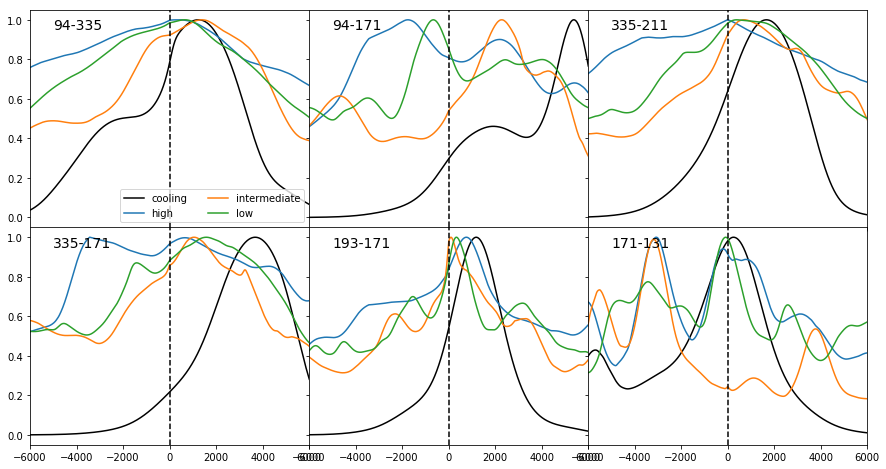

In [65]:
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    # cooling
    cc_cooling = tl_cooling.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_cooling.timelags,cc_cooling/cc_cooling.max(),color=f'k',ls='-',label='cooling')
    # high frequency
    cc_high = tl_high.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_high.timelags,cc_high/cc_high.max(),color=f'C0',ls='-',label='high')
    # intermediate frequency
    cc_intermediate = tl_intermediate.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_intermediate.timelags,cc_intermediate/cc_intermediate.max(),color=f'C1',ls='-',label='intermediate')
    # low frequency
    cc_low = tl_low.correlation_1d(f'{p[0]}', f'{p[1]}',*coords)
    ax.plot(tl_low.timelags,cc_low/cc_low.max(),color=f'C2',ls='-',label='low')
    ax.axvline(x=0,ls='--',color='k')
    ax.text(-5e3,0.95,'{}-{}'.format(*p),fontsize=14)
axes[0,0].set_xlim([-6e3,6e3])
axes[0,0].legend(loc=4,ncol=2)
plt.subplots_adjust(hspace=0,wspace=0)

## 2D Timelag Maps
Now, compute the timelag maps for several different channel pairs for all four of our different heating functions. From Viall and Klimchuk (2017), we want to look at the channel pairs,

* 94-335
* 94-171
* 335-211
* 335-171
* 193-171
* 171-131

Compute maps and histograms for each of these. Show grid of timelag maps, rows are the channel pairs, columns are the heating models. Finally, 

In [23]:
cooling_timelags = {}
for p in channel_pairs:
    cor_map,tl_map = tl_cooling.make_timelag_map(f'{p[0]}',f'{p[1]}')
    cooling_timelags['{}-{}'.format(*p)] = {
        'timelag_map':tl_map,
        'correlation_map':cor_map
    }

In [ ]:
for p in channel_pairs:
    (cooling_timelags['{}-{}'.format(*p)]['correlation_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/timelag_maps/timelag_map_{}_{}.fits'.format(*p)))
    (cooling_timelags['{}-{}'.format(*p)]['timelag_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/timelag_maps/correlation_map_{}_{}.fits'.format(*p)))

In [36]:
high_timelags = {}
for p in channel_pairs:
    cor_map,tl_map = tl_high.make_timelag_map(f'{p[0]}',f'{p[1]}')
    high_timelags['{}-{}'.format(*p)] = {
        'timelag_map':tl_map,
        'correlation_map':cor_map
    }

In [ ]:
for p in channel_pairs:
    (high_timelags['{}-{}'.format(*p)]['timelag_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/high_frequency/nei/timelag_maps/timelag_map_{}_{}.fits'.format(*p)))
    (high_timelags['{}-{}'.format(*p)]['correlation_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/high_frequency/nei/timelag_maps/correlation_map_{}_{}.fits'.format(*p)))

In [38]:
intermediate_timelags = {}
for p in channel_pairs:
    cor_map,tl_map = tl_intermediate.make_timelag_map(f'{p[0]}',f'{p[1]}')
    intermediate_timelags['{}-{}'.format(*p)] = {
        'timelag_map':tl_map,
        'correlation_map':cor_map
    }

In [ ]:
for p in channel_pairs:
    (intermediate_timelags['{}-{}'.format(*p)]['timelag_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/intermediate_frequency/nei/timelag_maps/timelag_map_{}_{}.fits'.format(*p)))
    (intermediate_timelags['{}-{}'.format(*p)]['correlation_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/intermediate_frequency/nei/timelag_maps/correlation_map_{}_{}.fits'.format(*p)))

In [39]:
low_timelags = {}
for p in channel_pairs:
    cor_map,tl_map = tl_low.make_timelag_map(f'{p[0]}',f'{p[1]}')
    low_timelags['{}-{}'.format(*p)] = {
        'timelag_map':tl_map,
        'correlation_map':cor_map
    }

In [ ]:
for p in channel_pairs:
    (low_timelags['{}-{}'.format(*p)]['timelag_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/low_frequency/nei/timelag_maps/timelag_map_{}_{}.fits'.format(*p)))
    (low_timelags['{}-{}'.format(*p)]['correlation_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/low_frequency/nei/timelag_maps/correlation_map_{}_{}.fits'.format(*p)))

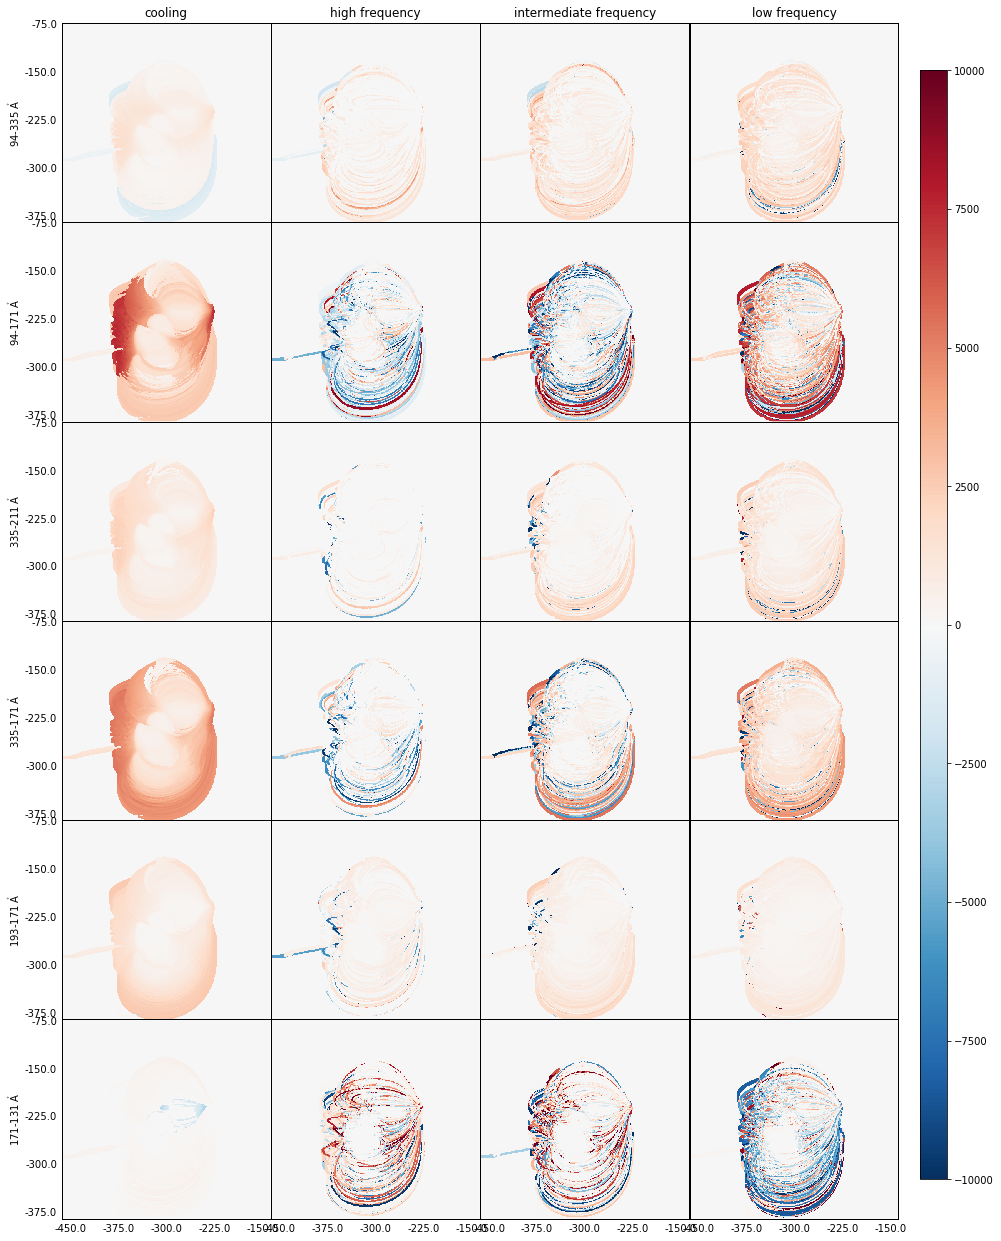

In [44]:
fig = plt.figure(figsize=(15,22))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,(c_a,c_b) in enumerate(channel_pairs):
    for j,heating in enumerate(['cooling','high_frequency','intermediate_frequency','low_frequency']):
        if heating == 'cooling':
            heating_dict = cooling_timelags
        if heating == 'high_frequency':
            heating_dict = high_timelags
        if heating == 'intermediate_frequency':
            heating_dict = intermediate_timelags
        if heating == 'low_frequency':
            heating_dict = low_timelags
        tmp = Map(heating_dict[f'{c_a}-{c_b}']['timelag_map'])
        tmp.plot_settings.update({'cmap':'RdBu_r','vmin':-1e4,'vmax':1e4})
        ax = fig.add_subplot(len(channel_pairs),4,4*i+j+1,projection=tmp)
        im = tmp.plot(annotate=False,title=False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0:
            lat.set_axislabel(f'{c_a}-{c_b} $\mathrm{{\mathring{{A}}}}$')
        if i<len(channel_pairs)-1:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        if i==0:
            ax.set_title(' '.join(heating.split('_')))
cbar = fig.colorbar(im, cax=cax)

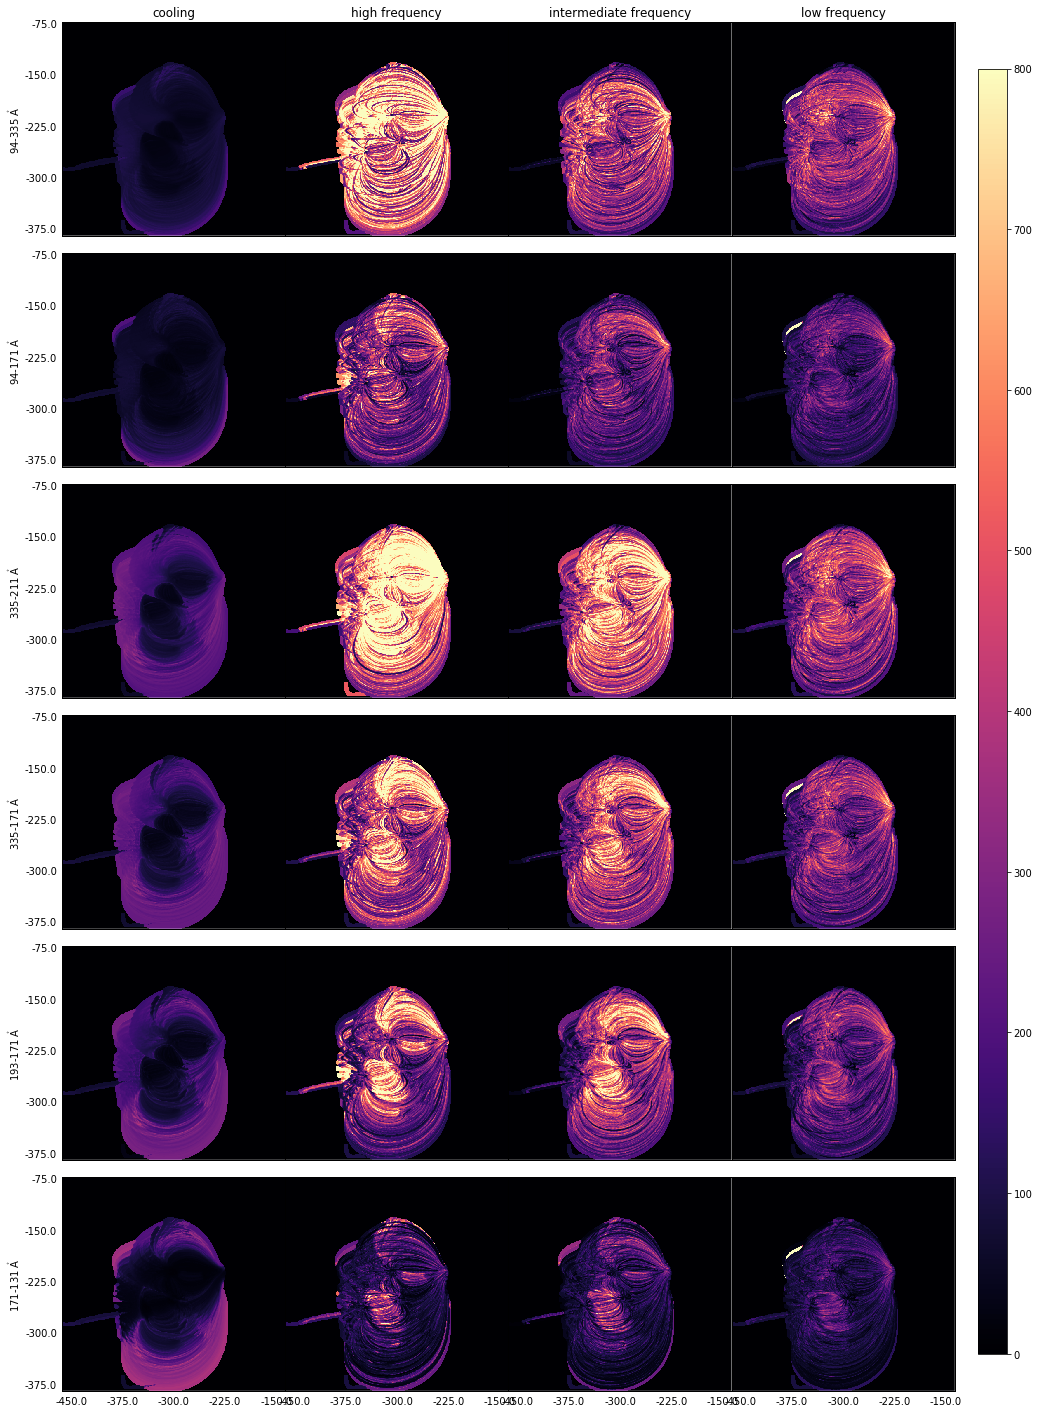

In [42]:
fig = plt.figure(figsize=(16,25.5))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/correlation_map_{}_{}.fits'
# cooling
for i,(c_a,c_b) in enumerate(channel_pairs):
    for j,heating in enumerate(['cooling','high_frequency','intermediate_frequency','low_frequency']):
        if heating == 'cooling':
            heating_dict = cooling_timelags
        if heating == 'high_frequency':
            heating_dict = high_timelags
        if heating == 'intermediate_frequency':
            heating_dict = intermediate_timelags
        if heating == 'low_frequency':
            heating_dict = low_timelags
        tmp = Map(heating_dict[f'{c_a}-{c_b}']['correlation_map'])
        tmp.plot_settings.update({'cmap':'magma','vmin':0,'vmax':8e2})
        ax = fig.add_subplot(len(channel_pairs),4,4*i+j+1,projection=tmp)
        im = tmp.plot(annotate=False,title=False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0:
            lat.set_axislabel(f'{c_a}-{c_b} $\mathrm{{\mathring{{A}}}}$')
        if i<len(channel_pairs)-1:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        if i==0:
            ax.set_title(' '.join(heating.split('_')))
cbar = fig.colorbar(im, cax=cax)

## Timelag Distributions

Finally, compare them on a histogram

Text(0.5,0,'timelag [s]')

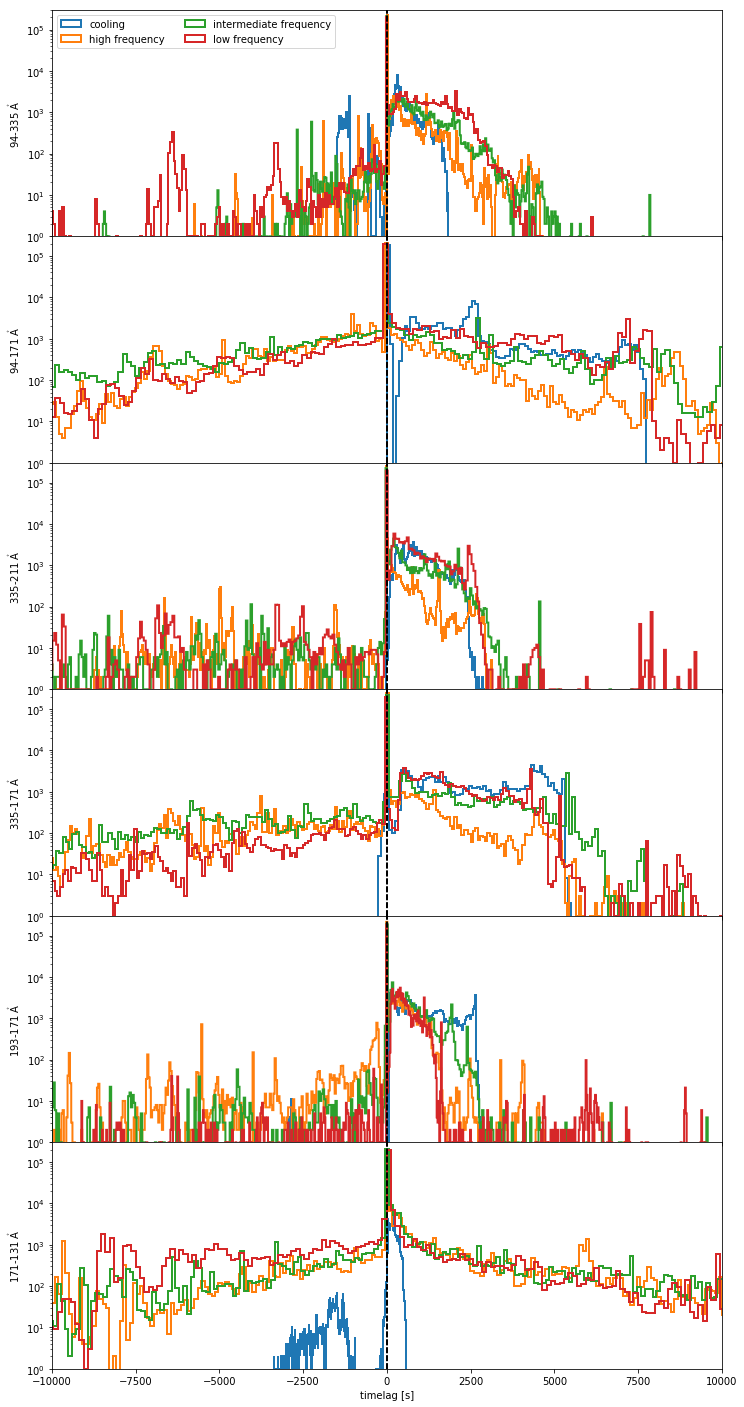

In [45]:
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'normed':False,}
fig,axes = plt.subplots(len(channel_pairs),1,figsize=(12,25),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    for j,heating in enumerate(['cooling','high_frequency','intermediate_frequency','low_frequency']):
        if heating == 'cooling':
            heating_dict = cooling_timelags
        if heating == 'high_frequency':
            heating_dict = high_timelags
        if heating == 'intermediate_frequency':
            heating_dict = intermediate_timelags
        if heating == 'low_frequency':
            heating_dict = low_timelags
        tmp = Map(heating_dict['{}-{}'.format(*p)]['timelag_map'])
        ax.hist(tmp.data.flatten(),**params,label=' '.join(heating.split('_')),color=f'C{j}',ls='-')
        ax.axvline(x=0,ls='--',color='k')
        if i==0:
            ax.legend(loc='best',ncol=2)
        ax.set_ylabel(r'{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
axes[0].set_xlim(-1e4,1e4)
axes[0].set_ylim(1,3e5)
axes[-1].set_xlabel(r'timelag [s]')

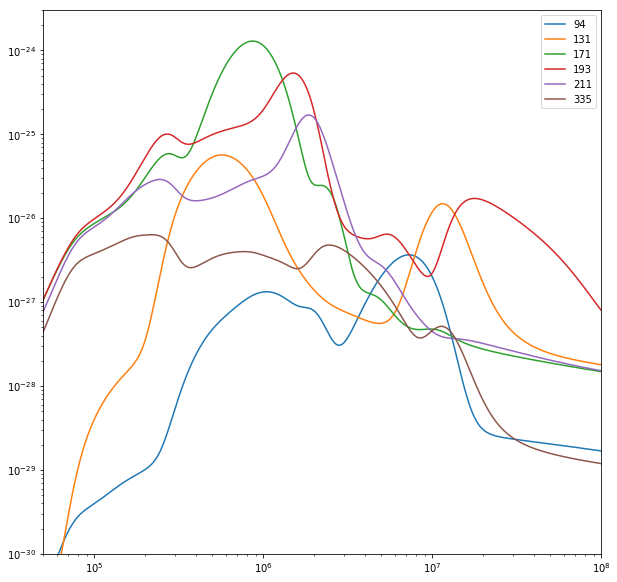

In [47]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
temperature_grid = np.logspace(4,9,1000)
for channel in aia_cooling.channels:
    resp = splev(temperature_grid, channel['temperature_response_spline'])
    ax.plot(temperature_grid,resp,label=channel['name'])
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1e-30,3e-24)
plt.xlim(5e4,1e8)
ax.legend()

## Computing Similarity to Observed Maps
One possible way to make a selection of the "best" heating model is to compute the observed timelags for all of these channels (using the same method as here) and then compute some sort of statistical distance between the distributions of timelags. A "pixel-by-pixel" comparison does not make much sense as this would likely be thrown off by the obvious issues with the field extrapolation and would not be a great test of the heating model itself.

## Dask Sandbox

In [73]:
tl_high.cubes['94'].shape[0]//20

25

In [16]:
with h5py.File('test_dask_timelag_cube.h5','w') as hf:
    for chan in tl_high.cubes:
        chunks = (tl_high.cubes[chan].shape[0]//20, tl_high.cubes[chan].shape[1]//20, tl_high.cubes[chan].shape[2])
        grp = hf.create_group(chan)
        dset = grp.create_dataset('data', data=tl_high.cubes[chan], chunks=chunks)
        meta = grp.create_group('metadata')
        for k in tl_high.meta_templates[chan]:
            try:
                meta.attrs[k] = tl_high.meta_templates[chan][k]
            except TypeError:
                continue

In [25]:
with h5py.File('test_dask_timelag_cube.h5','r') as hf:
    #meta_test = MetaDict({k: hf['94']['metadata'].attrs[k] for k in hf['94']['metadata'].attrs})
    meta_test = MetaDict(dict(hf['94']['metadata'].attrs))

In [26]:
meta_test

MetaDict([('simple', True),
          ('bitpix', -64),
          ('naxis', 2),
          ('naxis1', 543),
          ('naxis2', 519),
          ('crval1', -300.33769468849789),
          ('crval2', -228.11163436846201),
          ('cunit1', 'arcsec'),
          ('cunit2', 'arcsec'),
          ('hglt_obs', -6.6914090000000002),
          ('hgln_obs', 0.0),
          ('ctype1', 'HPLN-TAN'),
          ('ctype2', 'HPLT-TAN'),
          ('date-obs', '2011-02-12T15:32:42.00'),
          ('dsun_obs', 147657722880.69),
          ('rsun_obs', 976.16127369726507),
          ('cdelt1', 0.60069799999999995),
          ('cdelt2', 0.60069799999999995),
          ('crpix1', 272.0),
          ('crpix2', 260.0),
          ('instrume', 'AIA_4'),
          ('wavelnth', 94.0),
          ('telescop', 'SDO/AIA'),
          ('detector', 'AIA'),
          ('waveunit', 'angstrom'),
          ('bunit', 'cm ct / (cm pix s)'),
          ('tunit', 's'),
          ('t_obs', 24990.0),
          ('comment', ''),
     

In [32]:
hf = h5py.File('test_dask_timelag_cube.h5','r')
dask_array_94 = dask.array.from_array(hf['94']['data'], hf['94']['data'].chunks)
dask_array_171 = dask.array.from_array(hf['171']['data'], hf['171']['data'].chunks) 

In [34]:
foo = Map(np.array(dask_array_94[:,:,0]),MetaDict())

In [42]:
bar = dask_array_94[250:260,250:260,:].mean(axis=(0,1))

In [43]:
bar = bar.compute()

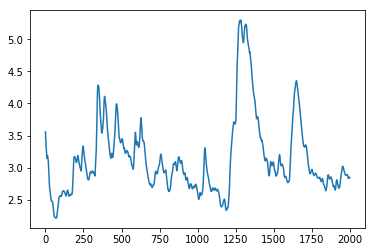

In [44]:
plt.plot(bar)

In [53]:
max_94 = dask_array_94.max(axis=2)
max_171 = dask_array_171.max(axis=2)

In [54]:
intensity_94_norm = dask_array_94 / dask.array.where(max_94==0, 1, max_94)[:,:,np.newaxis]
intensity_171_norm = dask_array_171 / dask.array.where(max_171==0, 1, max_171)[:,:,np.newaxis]

In [56]:
foo = intensity_94_norm.compute()

In [ ]:
intensity_94_norm.ar

In [57]:
foo.shape

(519, 543, 2000)

In [95]:
fft_94 = dask.array.fft.rfft(intensity_94_norm, axis=2, n=tl_high.timelags.shape[0])
fft_171 = dask.array.fft.rfft(intensity_171_norm, axis=2, n=tl_high.timelags.shape[0])
cc = dask.array.fft.irfft(fft_94 * fft_171, axis=2, n=tl_high.timelags.shape[0])

In [97]:
max_index_cc = np.argmax(cc,axis=2)

In [98]:
max_i = max_index_cc.compute()

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/worker.py:664: RuntimeWarning: invalid value encountered in true_divide
  return func(*map(execute_task, args))


In [107]:
hf.close()

In [104]:
hf

<Closed HDF5 file>

In [106]:
max_index_cc = None

In [110]:
cc = None

In [111]:
fft_171

dask.array<rfft, shape=(519, 543, 2000), dtype=complex128, chunksize=(25, 27, 2000)>